In [1]:
import sympy as sp
from sympy import oo
import numpy as np
from itertools import product
from scipy.linalg import eig
from sympy import diff
import time as time
import matplotlib.pyplot as plt
from sympy.plotting import plot
# %matplotlib notebook 
%matplotlib inline
from IPython.display import Math
sp.init_printing()

r, r1, r2, zeta, zeta1, zeta2 = sp.symbols("r, r1, r2, zeta, zeta1, zeta2")
n = sp.Symbol('n',integer=True)

In [2]:
def STO(zeta, n, r=r):
    return (2*zeta)**n*(2*zeta/sp.factorial(2*n))**(1/2)*r**(n-1)*sp.exp(-zeta*r)

In [3]:
# S Overlap Integrate
def S_int(f1, f2):
    return sp.integrate(f1*f2*r*r ,(r, 0, +oo))

In [4]:
# H core = kinetics energy + electron and nuclear potential energy
def H_int(f1, f2, Z):
    return sp.integrate(f1*(-((1/2)*(1/r)*diff(diff(r*f2, r), r))-((Z/r)*f2))*r*r, (r,0,+oo))

In [5]:
# Returns the core hamiltonian matrix
def H_matrix(fs, Z):

    H = np.zeros((len(fs),len(fs)))
    for i in range(len(fs)):
        for j in range(len(fs)):
            H[i, j] =  H_int(fs[i], fs[j], Z)

    return H    

# Returns the overlap matrix
def S_matrix(fs):

    S = np.zeros((len(fs),len(fs)))
    for i in range(len(fs)):
        for j in range(len(fs)):
            S[i, j] =  S_int(fs[i], fs[j])

    return S

In [6]:
def Repulsion_electron(zetas):
    
    f1=STO(zetas[0][0], zetas[0][1], r1)
    f2=STO(zetas[1][0], zetas[1][1], r1)
    f3=STO(zetas[2][0], zetas[2][1], r2)
    f4=STO(zetas[3][0], zetas[3][1], r2)
    fs = [f1, f2, f3, f4]
    
    B = (1/r1)*sp.integrate(f3*f4*r2*r2 ,(r2, 0, r1)) + sp.integrate((1/r2)*f3*f4*r2*r2 ,(r2, r1, +oo))
    A = sp.integrate(f1*f2*r1*r1*B ,(r1, 0, +oo))
    return A

In [7]:
# Calculates Density matrix
# P need to be changed if the atom have unpaired electron
def P2s_matrix(Co1, Co2):

    P = np.zeros([Co1.shape[0], Co1.shape[0]])

    for t in range(Co1.shape[0]):
        for u in range(Co1.shape[0]):
            P[t][u] = 2* Co1[t][0]*Co1[u][0]
    return P

In [8]:
# Calculates Density matrix
# P need to be changed if the atom have unpaired electron
def P1s_matrix(Co1, Co2):

    P = np.zeros([Co1.shape[0], Co1.shape[0]])

    for t in range(Co1.shape[0]):
        for u in range(Co1.shape[0]):
            P[t][u] = 2* Co1[t][0]*Co1[u][0] + Co2[t][1]*Co2[u][1]
    return P

In [9]:
def R_matrix(zetas):
    R = np.zeros((len(zetas), len(zetas), len(zetas), len(zetas)))

    rs = list(product(range(len(zetas)),repeat=2))
    tu = list(product(range(len(zetas)),repeat=2))

    for r, s in rs:
        for t, u in tu:
            R[r,s,t,u] = Repulsion_electron((zetas[r], zetas[s], zetas[t], zetas[u]))
    return R

# Caculate G Matrix for 1s
def G1s_matrix(zetas, Co1, Co2, R):

    G = np.zeros((Co1.shape[0], Co1.shape[0]))
    P = P1s_matrix(Co1, Co2)
    
    rs = list(product(range( Co1.shape[0]),repeat=2))
    tu = list(product(range( Co1.shape[0]),repeat=2))

    for r, s in rs:
        g = 0
        for t, u in tu:
            int1 = R[r, s, t, u]
            int2 = R[r, u, t, s]
#             print('({0}{1}|{2}{3}): {4}'.format(r, s, t, u, int1))
            g+= P[t, u] * (int1 - 0.5 * int2)
        G[r, s] = g
    return G

# Returns the Fock matrix
def F1s_matrix(fs, Z, zetas, Co1, Co2, R):
    return H_matrix(fs, Z) + G1s_matrix(zetas, Co1, Co2, R)

In [15]:
# Caculate G Matrix for 2s
def G2s_matrix(zetas, Co1, Co2, R):

    G = np.zeros((Co1.shape[0], Co1.shape[0]))

    P = P2s_matrix(Co1, Co2)
    
    rs = list(product(range( Co2.shape[0]),repeat=2))
    tu = list(product(range( Co2.shape[0]),repeat=2))

    for r, s in rs:
        g = 0
        for t, u in tu:
            int1 = R[r, s, t, u]
            int2 = R[r, u, t, s]
#             print('({0}{1}|{2}{3}): {4}'.format(r, s, t, u, int1))
            g+= P[t, u] * (int1 - 0.5 * int2)
        G[r, s] = g
    return G

# Returns the Fock matrix
def F2s_matrix(fs, Z, zetas, Co1, Co2, R):
    return H_matrix(fs, Z) + G2s_matrix(zetas, Co1, Co2, R)

In [11]:
# slove secular equation, return the energy and improved coeffients
# the energy here is orbital energy for 1 electron
def secular_eqn(F, S):
    ei, C = eig(F, S)
    
    # sort eigvalue and eigvector from lower to higher
    idx = ei.argsort()[::1]   
    ei = ei[idx]
    C = C[:,idx]

    # eigvector from scipy.linalg.eig is not normalized, which is a bug
    # this is to fix it
    Co = np.zeros((C.shape[0],C.shape[0]))
    inte = np.matmul(np.matmul(C.T, S), C)
    for i in range(C.shape[0]):
        for j in range(C.shape[0]):
            Co[j][i]=C[j][i]/np.sqrt(inte[i][i])

    return ei, Co

In [12]:
# return energy of atom
def get_E0(e1, e2, P1s, P2s, H):
    
    E0 = e1[0].real + 0.5 * e2[1].real + 0.5*(P1s*H).sum()
    return E0

------------------------------ Initialization ------------------------------
------------------------- Ignore repulsion integral ------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

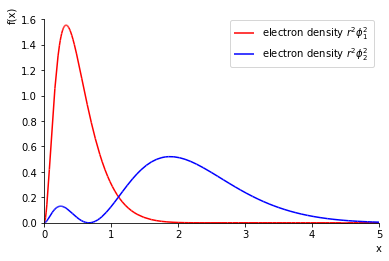

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

------------------------------ Iteration 1 ------------------------------
------- Iteration 1 needs more time to caculate Repulsion Integral ------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

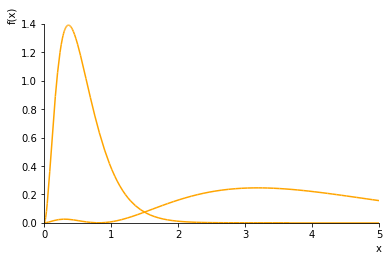

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 1.6 s
------------------------------ Iteration 2 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

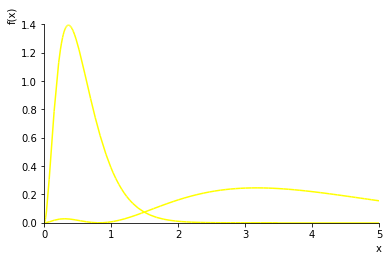

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 1.7 s
------------------------------ Iteration 3 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

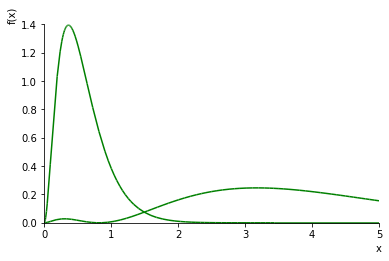

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 1.7 s
------------------------------ Iteration 4 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

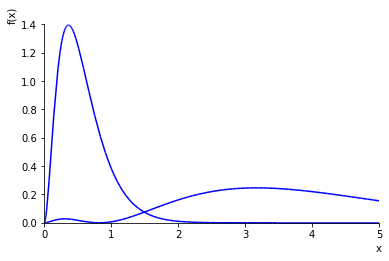

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 1.7 s
------------------------------ Iteration 5 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

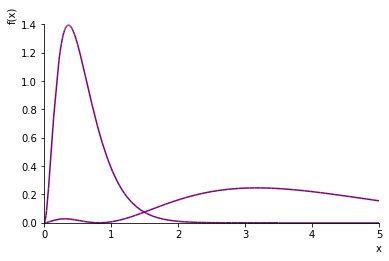

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 1.5 s
------------------------------ Iteration 6 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

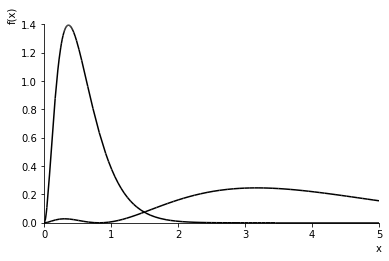

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 1.6 s
------------------------------ Iteration 7 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

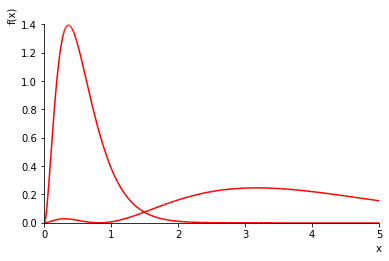

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 1.6 s
------------------------------ Iteration 8 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

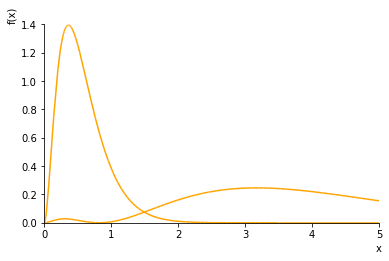

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 1.7 s
------------------------------ Iteration 9 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

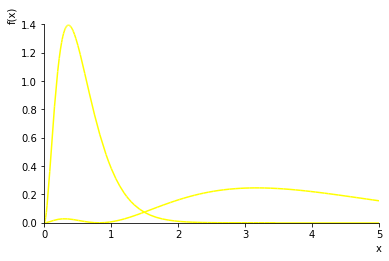

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 1.7 s
------------------------------ Iteration 10 ------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

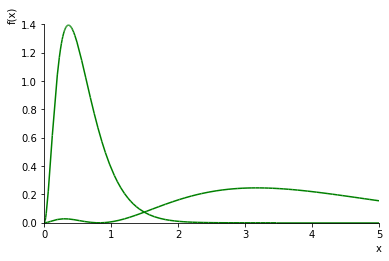

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time used: 1.6 s


In [16]:
# input 
# input for zeta
zetas = [[4.24, 1], [2.26, 1], [1.16, 2], [0.6, 2]]
# input nuclear charge (element number)
Z = 3

# build basis function
f1=STO(zetas[0][0], zetas[0][1])
f2=STO(zetas[1][0], zetas[1][1])
f3=STO(zetas[2][0], zetas[2][1])
f4=STO(zetas[3][0], zetas[3][1])
fs = [f1, f2, f3, f4]

# initialization
#R = np.zeros((len(zetas), len(zetas), len(zetas), len(zetas)))
H = H_matrix(fs, Z)
S = S_matrix(fs)
e1, Co1 = secular_eqn(H, S)
e2, Co2 = secular_eqn(H, S)
P1 = P1s_matrix(Co1, Co2)
P2 = P2s_matrix(Co1, Co2)
scf_H = get_E0(e1, e2, P1, P2, H)

##############################################print information below#################################################
print('-'*30, "Initialization", '-'*30)
print('-'*25, "Ignore repulsion integral", '-'*24)
display(Math('\zeta_1 = {0} \quad \zeta_2 = {1} \quad \zeta_3 = {2} \quad \zeta_4 = {3}'.format(format(zetas[0][0], '0.3f'), format(zetas[1][0], '0.3f'), format(zetas[2][0], '0.3f'),format(zetas[3][0], '0.3f')))) 
display(Math('Orbitals:'))
display(Math(' \phi_1 = c_{11} \chi_1 + c_{21} \chi_2 + c_{31} \chi_3 + c_{41} \chi_4'))
display(Math(' \phi_2 = c_{12} \chi_1 + c_{22} \chi_2 + c_{32} \chi_3 + c_{42} \chi_4'))    
display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3}'.format(format(Co1[0][0], '0.3f'), format(Co1[1][0], '0.3f'), format(Co1[2][0], '0.3f'), format(Co1[3][0], '0.3f')))) 
display(Math('c12 = {0} \quad c22 = {1} \quad c32 = {2} \quad c42 = {3}'.format(format(Co2[0][1], '0.3f'), format(Co2[1][1], '0.3f'), format(Co2[2][1], '0.3f'), format(Co2[3][1], '0.3f'))))     

# plot density graph
colorlist = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black']
phi1 = Co1[0,0]*f1+Co1[1,0]*f2+Co1[2,0]*f3+Co1[3,0]*f4
phi2 = Co2[0,1]*f1+Co2[1,1]*f2+Co2[2,1]*f3+Co2[3,1]*f4
density_1 = phi1*phi1*r*r
density_2 = phi2*phi2*r*r    
p = plot((density_1, (r, 0, 5)), (density_2, (r, 0, 5)), show = False, legend = True)
p[0].label = 'electron density $r^2 \phi_1^2$ '
p[1].label = 'electron density $r^2 \phi_2^2$ '    
p[0].line_color = colorlist[0]
p[1].line_color = 'blue'
p.show()
# print energy result
display(Math(' \epsilon_1 \; for \; \phi_1  = {0} '.format(format(e1[0].real, '0.3f'))))    
display(Math(' \epsilon_2 \; for \; \phi_1 = {0} '.format(format(e2[1].real, '0.3f'))))        
display(Math(' Hartree \ Fork \; atom \; energy = {0} \ hartree = {1} \ eV'.format(format(scf_H, '0.5f'), format(scf_H*27.211, '0.5f'))))    
##############################################print information above#################################################

for i in range(10):
    print('-'*30, "Iteration", i + 1, '-'*30)
    if(i==0):
        print('-'*7, "Iteration 1 needs more time to caculate Repulsion Integral", '-'*6)
        start = time.time()
        #R = R_matrix(zetas)
    else:
        start = time.time()
    F1 = F1s_matrix(fs, Z, zetas, Co1, Co2, R)
    F2 = F2s_matrix(fs, Z, zetas, Co1, Co2, R)
    S = S_matrix(fs)
    e1, Co1 = secular_eqn(F1, S)
    e2, Co2 = secular_eqn(F2, S)
    #e[0] += get_K21(Co, R)/2 #first order correction
    P1 = P1s_matrix(Co1, Co2)
    P2 = P2s_matrix(Co1, Co2)
    scf_H = get_E0(e1, e2, P1, P2, H)
    ##########################################print information below#################################################
    # print information
    display(Math('\zeta_1 = {0} \quad \zeta_2 = {1} \quad \zeta_3 = {2} \quad \zeta_4 = {3}'.format(format(zetas[0][0], '0.3f'), format(zetas[1][0], '0.3f'), format(zetas[2][0], '0.3f'),format(zetas[3][0], '0.3f')))) 
    display(Math('Orbitals:'))
    display(Math(' \phi_1 = c_{11} \chi_1 + c_{21} \chi_2 + c_{31} \chi_3 + c_{41} \chi_4'))
    display(Math(' \phi_2 = c_{12} \chi_1 + c_{22} \chi_2 + c_{32} \chi_3 + c_{42} \chi_4'))    
    display(Math('c11 = {0} \quad c21 = {1} \quad c31 = {2} \quad c41 = {3}'.format(format(Co1[0][0], '0.3f'), format(Co1[1][0], '0.3f'), format(Co1[2][0], '0.3f'), format(Co1[3][0], '0.3f')))) 
    display(Math('c12 = {0} \quad c22 = {1} \quad c32 = {2} \quad c42 = {3}'.format(format(Co2[0][1], '0.3f'), format(Co2[1][1], '0.3f'), format(Co2[2][1], '0.3f'), format(Co2[3][1], '0.3f'))))     
    # plot density graph
    phi1 = Co1[0,0]*f1+Co1[1,0]*f2+Co1[2,0]*f3+Co1[3,0]*f4
    phi2 = Co2[0,1]*f1+Co2[1,1]*f2+Co2[2,1]*f3+Co2[3,1]*f4
    density_1 = phi1*phi1*r*r
    density_2 = phi2*phi2*r*r    
    p = plot((density_1, (r, 0, 5)), (density_2, (r, 0, 5)), show = False)
    p[0].label = None 
    p[1].label = None     
    p[0].line_color = colorlist[i+1]
    p[1].line_color = colorlist[i+1]
    #p.extend(p1)
    p.show() 
    # print energy result
    display(Math(' \epsilon_1 \; for \; \phi_1  = {0} '.format(format(e1[0].real, '0.3f'))))    
    display(Math(' \epsilon_2 \; for \; \phi_1 = {0} '.format(format(e2[1].real, '0.3f'))))        
    display(Math(' Hartree \ Fork \; atom \; energy = {0} \ hartree = {1} \ eV'.format(format(scf_H, '0.5f'), format(scf_H*27.211, '0.5f'))))    
    stop = time.time()
    print('Time used:',format(stop-start, '0.1f'),'s')
    ##########################################print information above#################################################

In [17]:
print(sp.integrate(density_1 ,(r, 0, +oo)))
print(sp.integrate(density_1/r ,(r, 0, +oo)))
print(sp.integrate(density_1*r ,(r, 0, +oo)))
print(sp.integrate(density_1*r*r ,(r, 0, +oo)))

print(sp.integrate(density_2 ,(r, 0, +oo)))
print(sp.integrate(density_2/r ,(r, 0, +oo)))
print(sp.integrate(density_2*r ,(r, 0, +oo)))
print(sp.integrate(density_2*r*r ,(r, 0, +oo)))

1.00000000000000
2.67983395801961
0.576149847729386
0.452301927449500
1.00000000000000
0.333231538542803
4.09511343000952
20.1344889480488
